In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sc
import dataframe_image as dfi
from scipy.stats import norm
import time

In [2]:
pd.set_option('display.max_columns', 100)

In [3]:
np.random.seed(42)

In [4]:
sns.set_style("dark")

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Helper functions

In [6]:
def excel_to_csv (excel_file_name, suffixe, cols_droped=[0,1,3]):
    
    df_excel = pd.read_excel(excel_file_name, parse_dates=False, sheet_name=None, header=3)
    nbr_sheet = len(list(df_excel.values()))
    delete_list = ['CHF',  'EUR', 'GBP', 'Autre', 'USD', 'Autres',
                                  'NON EUR', 'CAD', 'AUD', 'JPY', 'EMCUR',
                                  'Courbe CHF - duration', 'Courbe EUR - duration',
                                  'Courbe USD - duration', 'Courbe Monde - duration',
                                  '% Gouvernementales - courbe CHF', '% Corporate - courbe CHF',
                                  '% Gouvernementales - courbe EUR', '% Corporate - courbe EUR',
                                  '% Gouvernementales - courbe USD', '% Corporate - courbe USD',
                                  '% Gouvernementales - courbe Monde', '% Corporate - courbe Monde',
                                  '% Gouvernementales - Courbe CHF', '% Corporate - Courbe CHF',
                                  '% Gouvernementales - Courbe EUR', '% Corporate - Courbe EUR',
                                  '% Gouvernementales - Courbe USD', '% Corporate - Courbe USD',
                                  '% Gouvernementales - Courbe Monde', '% Corporate - Courbe Monde']
    for i in range(nbr_sheet):
        df = list(df_excel.values())[i]
        sheet_name = list(df_excel.keys())[i]
        if 'No ISIN' not in df.columns:
            continue
        df.dropna(how='all', inplace=True)
        df = df[df['No ISIN'].notna()]
        df = df[-df['No ISIN'].isin(delete_list)]
        df.drop(df.columns[cols_droped], axis=1, inplace=True)
        list_date = list(df.columns)[1:]
        df = df.melt(id_vars='No ISIN', value_vars=list_date, var_name='histo_date', value_name='weight')
        df.dropna(subset=['weight'], inplace=True)
        df = df[df['weight'] != 0]
        df['portfolio'] = suffixe
        df['strategie'] = sheet_name
        df['weight'] = df['weight'].astype('float64')
        df['weight'] = df['weight'].round(4)
        if i==0:
            df_port = df
        if i!=0:
            df_port = pd.concat([df_port, df])
            
    return df_port

In [7]:
def port_filter(portfolio):
    
    portfolio['No ISIN'].replace({
    'Inflation Bond CHF': 'AXGICCH LX Equity',
    'Inflation Bond USD': 'TIPIV Index',
    'Inflation Bond EUR': 'INAVIS31 Index',
    
    'Total Return CHF': 'GSMBIAS LX Equity',
    'Total Return EUR': 'INGLAC Index',
    'Total Return USD': 'INSPFU Index',
    
    'HYBRIDUSD': 'FIDYUHG LX Index',
    'HYBRIDEUR': 'FIDYACE LX Index',
    'HYBRIDCHF': 'NBCHCPA ID Equity',
    
    'UCBIFX02 Index': 'MORSCUA LX Index',
    'UCBIFX28 Index': 'SWBHCHP LX Equity',
    'UCBIFX14 Index': 'MOBILCI LX Index',
    
    'Cat Bond USD': 'LEUPCBU SW Index',
    'Cat Bond CHF': 'SGCIFCH LX Equity',
    'Cat Bond EUR': 'LEUPCBE SW Index',

    'LG30TRCH Index': 'H00039CH Index',
    'JPGCHFCP Index': 'CSIFMFH SW Equity',
    'Contrepartie CHF': 'CHF Curncy',
    'Contrepartie EUR': 'EUR Curncy',
    'Contrepartie USD': 'BBDXY Index',
    'AURLNCHF Curncy': 'AURLNCHF CURNCY',
    'aurlnchf curncy': 'AURLNCHF CURNCY',
    'aurlneur curncy': 'AURLNEUR CURNCY',
    'SBWG13U INDEX': 'SBWG13U Index',
    'LF89TRCH index': 'LF89TRCH Index',
    'H30909US INDEX': 'H30909US Index',
    'H30909EU INDEX': 'H30909EU Index',
    'SBWG10U INDEX': 'SBWG10U Index',
    'SBWG10CH INDEX': 'ZKWXBHN SW Equity',
    'SBWG10CH Index': 'ZKWXBHN SW Equity',
    'SBWGNSUU Index': 'IGLO LN Equity',
    'JHCC1R10 Index': 'X03H SW Equity',
    'M7CXSSD Index' : 'IJPC SW Equity'
    }, inplace=True)

    return portfolio

In [8]:
def get_all_isin(taa_port, curr=None, histo_date=None, strat=None):
    if curr is not None:
        if histo_date is None:
            if strat is None:
                all_isin = taa_port[taa_port['strategie'].str.contains(curr)]
            else:
                all_isin = taa_port[(taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
        else:
            if strat is None:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'].str.contains(curr))]
            else:
                all_isin = taa_port[(taa_port['histo_date'] == histo_date) & (taa_port['strategie'] == strat) & (taa_port['strategie'].str.contains(curr))]
    else:
        if histo_date is None:
            all_isin = taa_port
        else:
            all_isin = taa_port[taa_port['histo_date'] == histo_date]
        
    return pd.DataFrame(all_isin['No ISIN'].unique(), columns=['No ISIN'])

In [9]:
def get_all_strat(taa_port, curr=None):
    if curr is not None:
        all_strat = list(taa_port[taa_port.strategie.str.contains(curr)]['strategie'].unique())
    else:
        all_strat = list(taa_port['strategie'].unique())
        
    return all_strat

In [10]:
def get_weight(taa_port, strategie, histo_date):
    return taa_port[(taa_port['strategie'] == strategie) & (taa_port['histo_date'] == histo_date)][['No ISIN', 'weight']]

In [11]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [12]:
def round_nearest(x, a):
    return round(x / a) * a

In [13]:
def data_filter(data_excel, port, curr, strat=None, date=None):   
    data = data_excel.copy()
    all_isin_port = get_all_isin(port, strat=strat, curr=curr, histo_date=date)
    list_isin = list(all_isin_port['No ISIN'])
    data = data[list_isin]
    num_assets_data = data.shape[1]
    return data

In [14]:
def get_ret_cov(data):  
    daily_returns = data.pct_change()
    annual_returns = ((1 + daily_returns.mean())**252 - 1).values
    daily_cov = daily_returns.cov()
    annual_cov = daily_cov.values * 252
    return annual_returns, annual_cov

In [15]:
def sigma_to_sharp (weights, annual_returns, annual_cov):
    
    port_ret = weights @ annual_returns
    port_vol = np.sqrt(weights.T @ annual_cov @ weights )
    if port_vol == 0:
        port_sharp = 0
    else:
        port_sharp = port_ret / port_vol
    
    return port_ret, port_vol, port_sharp

In [16]:
def get_all_dates(taa_port, strat=None):
    if strat is not None:
        all_dates = taa_port[taa_port.strategie == strat]['histo_date'].unique()
    else:
        all_dates = taa_port['histo_date'].unique()
    return all_dates

In [17]:
def volatility_comparison(all_strat, all_dates, saa_date='2020-12-31'):
    
    # SAA
    df_vol_strats_saa = pd.DataFrame(columns=all_strat)

    for strat in all_strat:

        portfolio = get_weight(saa_port, strat, saa_date).reset_index(drop=True)
        portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
        portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
        weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
        port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
        df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                            'sharpe_ratio': port_sharpe, 'date': saa_date}, index=[0])

        df_temp.reset_index(inplace=True, drop=True)
        df_vol_strats_saa[strat] = df_temp.volatility

    df_vol_strats_saa.index = df_temp.date
    df_vol_strats_saa = df_vol_strats_saa * 100

    # TAA
    df_vol_strats = pd.DataFrame(columns=all_strat)
    for i, strat in enumerate(all_strat):

        df_port = pd.DataFrame(columns=['returns', 'volatility', 'sharpe_ratio', 'date'])
        for date in all_dates:
            portfolio = get_weight(taa_port, strat, date).reset_index(drop=True)
            portfolio = pd.merge(portfolio, all_isin, how='outer', on='No ISIN').fillna(0).drop_duplicates()
            portfolio = portfolio.set_index('No ISIN').reindex(list(all_isin['No ISIN']))
            weights = np.array( portfolio.weight / np.sum(portfolio.weight) )
            port_ret, port_vol, port_sharpe = sigma_to_sharp(weights, annual_returns, annual_cov)
            df_temp = pd.DataFrame(data={'returns': port_ret, 'volatility': port_vol,
                                'sharpe_ratio': port_sharpe, 'date': date}, index=[0])
            df_port = df_port.append(df_temp)

        df_port.reset_index(inplace=True, drop=True)
        # df_port.date = df_port.date.dt.strftime('%d/%m/%Y')

        df_vol_strats[strat] = df_port.volatility

    df_vol_strats.index = df_port.date
    df_vol_strats = df_vol_strats * 100
    df_vol_strats_diff = df_vol_strats - df_vol_strats_saa.iloc[0]
    df_vol_strats_pct = (df_vol_strats - df_vol_strats_saa.iloc[0]) / df_vol_strats_saa.iloc[0]
    df_vol_strats_pct *= 100
    return df_vol_strats, df_vol_strats_diff, df_vol_strats_pct

# Data preparation

In [18]:
indice_excel = pd.read_excel('data/fund_data.xlsx', sheet_name='indice', header=0, parse_dates=False)
indice_excel = indice_excel[['Nom', 'Valeur', 'PP_L1', 'PP_CHF_L2']].rename(columns={'Valeur': 'No ISIN'})
classe_data = port_filter(indice_excel)

In [19]:
taa_port_excel = excel_to_csv('data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)

In [21]:
saa_port_excel = excel_to_csv('data/saa.xlsx', 'PP', [1])
saa_port_excel.drop(columns='portfolio', inplace=True)
saa_port_excel = port_filter(saa_port_excel)

In [22]:
taa_port = taa_port_excel.copy()
saa_port = saa_port_excel.copy()

In [23]:
date = '2020-12-31'
curr = 'CHF'
port = saa_port

In [24]:
data_excel = pd.read_excel('data/indices_tickers_pp.xlsx', sheet_name='close_price', skiprows=[0,1,2,4,5,6,7])
data_excel.rename(columns = { data_excel.columns[0]: "Dates" }, inplace = True)
data_excel['Dates'] = pd.to_datetime(data_excel['Dates'], yearfirst=True, format="%d/%m/%Y")
data_excel = data_excel.fillna(method='ffill')
data_excel.index = data_excel['Dates']
data_excel = data_excel.drop(columns=['Dates'])
data_excel_futur = data_excel.loc[date:]
data_excel_histo = data_excel.loc[:date]

In [25]:
all_strategies = get_all_strat(port, curr)
all_isin_port = get_all_isin(port, curr=curr, histo_date=date)

In [26]:
taa_port_excel = excel_to_csv('data/taa.xlsx', 'PP')
taa_port_excel.drop(columns='portfolio', inplace=True)
taa_port_excel = port_filter(taa_port_excel)
taa_port = taa_port_excel.copy()

In [28]:
all_dates = get_all_dates(taa_port)
all_dates = all_dates[range(13, len(all_dates), 1)]
saa_date = pd.to_datetime('2020-12-31')
all_isin = get_all_isin(taa_port, curr=curr)
data = data_excel.copy()
data = data[list(all_isin['No ISIN'])]
annual_returns, annual_cov = get_ret_cov(data)

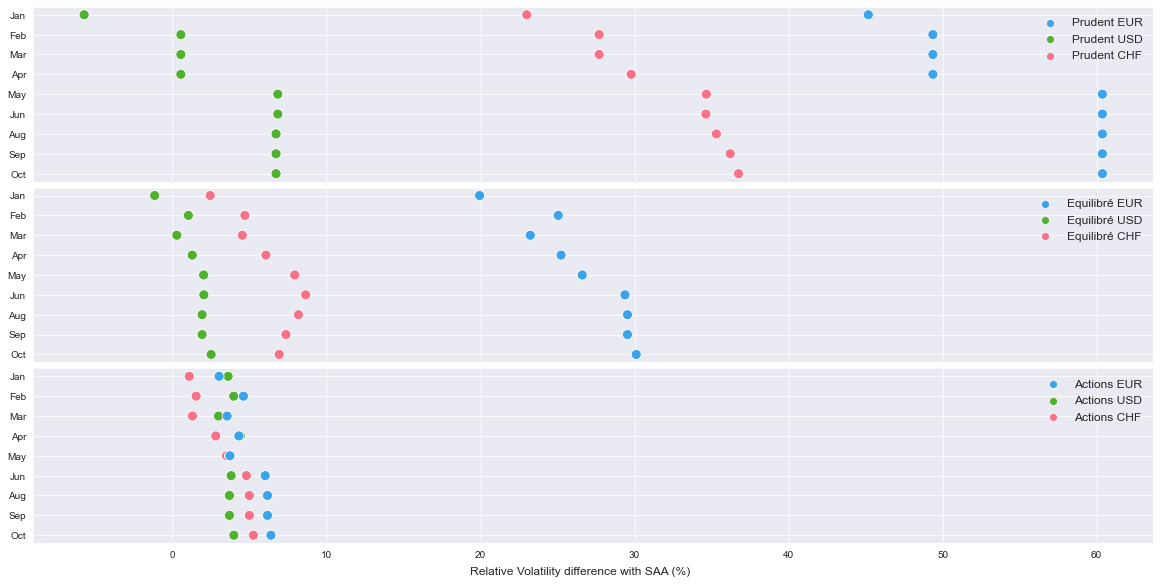

In [30]:
all_all_strats = ['Prudent', 'Equilibré', 'Actions']
all_dates = get_all_dates(taa_port)
all_dates = all_dates[range(15, len(all_dates), 1)]

fig, axs = plt.subplots(3,1, figsize=(16,8), sharex=True, sharey=True, constrained_layout=True)
axs = axs.ravel()

for i, all_strat in enumerate(all_all_strats):
    all_strat = [all_strat + ' CHF', all_strat + ' USD',all_strat + ' EUR']
    df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat, all_dates)
    
    #subplot
    data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
    data.date = data.date.dt.strftime('%b')
    
    pal = sns.color_palette("husl", 3)

    sns.scatterplot(ax=axs[i], data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100)

    handles, labels = axs[i].get_legend_handles_labels()
    lgd = axs[i].legend(reversed(handles), reversed(labels), bbox_to_anchor = (1, 1), fontsize=12, frameon=False)

    
    # plt.locator_params(axis='x', nbins=15)
    axs[i].grid(b=True, which='major', color='white', linestyle='-')
    axs[i].set(xlabel=None)
    axs[i].set(ylabel=None)

#fig.suptitle('Volatility relative difference with SAA (Dec. 2020) at each rebalance date \n Comparison between currencies and strategies', fontsize=20, fontweight='bold')
fig.supxlabel('Relative Volatility difference with SAA (%)', fontsize=12)
plt.savefig('pp_output/analyse/volatility_diff_all.png', dpi=300, bbox_inches='tight')
plt.show()

In [32]:
curr = 'CHF'
all_strat = get_all_strat(taa_port, curr=curr)
all_dates = get_all_dates(taa_port)
all_dates = all_dates[range(13, len(all_dates), 1)]
df_vol_strats, df_vol_strats_diff, df_vol_strats_pct = volatility_comparison(all_strat, all_dates)

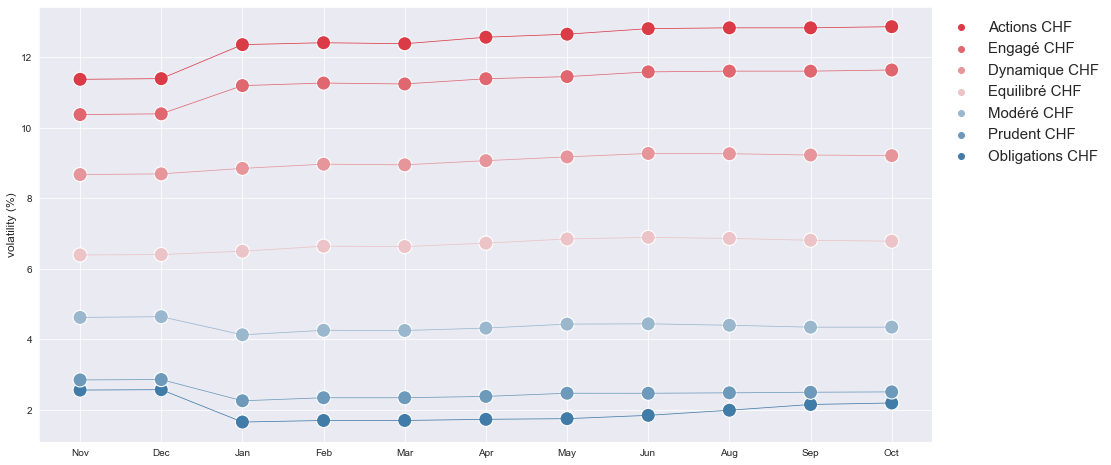

In [33]:
# display(df_vol_strats.round(2).dropna())

data = df_vol_strats.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='date', y='volatility', hue='strategie', palette=pal, s=200)
sns.lineplot(ax=ax, data=data, x='date', y='volatility', hue='strategie', palette=pal, lw=0.75, legend=False)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(reversed(handles), reversed(labels), bbox_to_anchor = (1, 1), fontsize=15, frameon=False)

plt.xlabel(None)
plt.ylabel('volatility (%)', fontsize=12)
#plt.title('Evolution of the average annualized volatility at each rebalance date (TAA) \n comparison between strategies', fontweight='bold', fontsize=15)

ax.grid(b=True, which='major', color='white', linestyle='-')

plt.savefig('pp_output/analyse/volatility_evolution.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

plt.show()

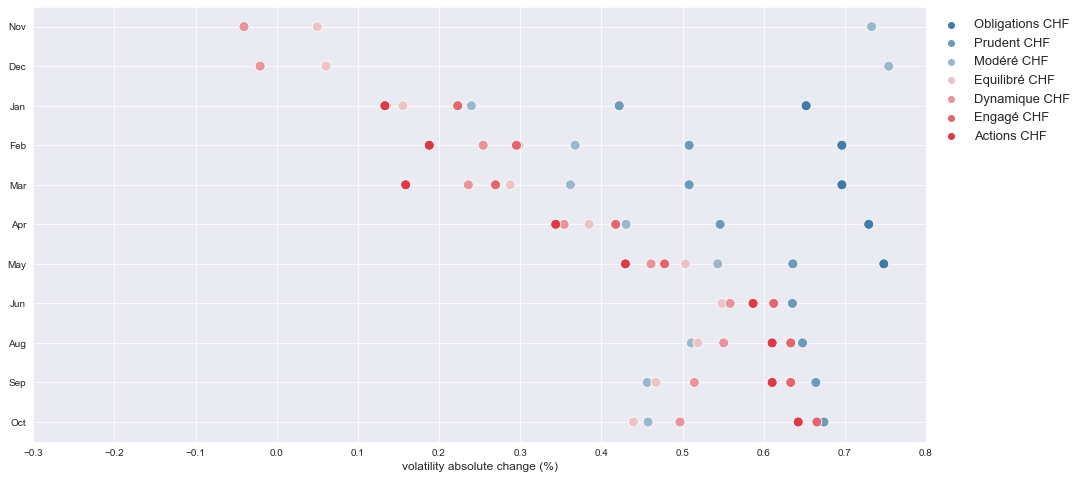

In [34]:
# display(df_vol_strats_diff.round(2).dropna())

data = df_vol_strats_diff.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100, legend=True)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor = (1, 1), fontsize=13, frameon=False)

plt.ylabel(None)
plt.xlabel('volatility absolute change (%)', fontsize=12)
#plt.title('Volatility absolute difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
plt.xlim(-0.3, 0.8)
ax.grid(b=True, which='major', color='white', linestyle='-')


plt.savefig('pp_output/analyse/volatility_abs_diff.png', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=300)

plt.show()

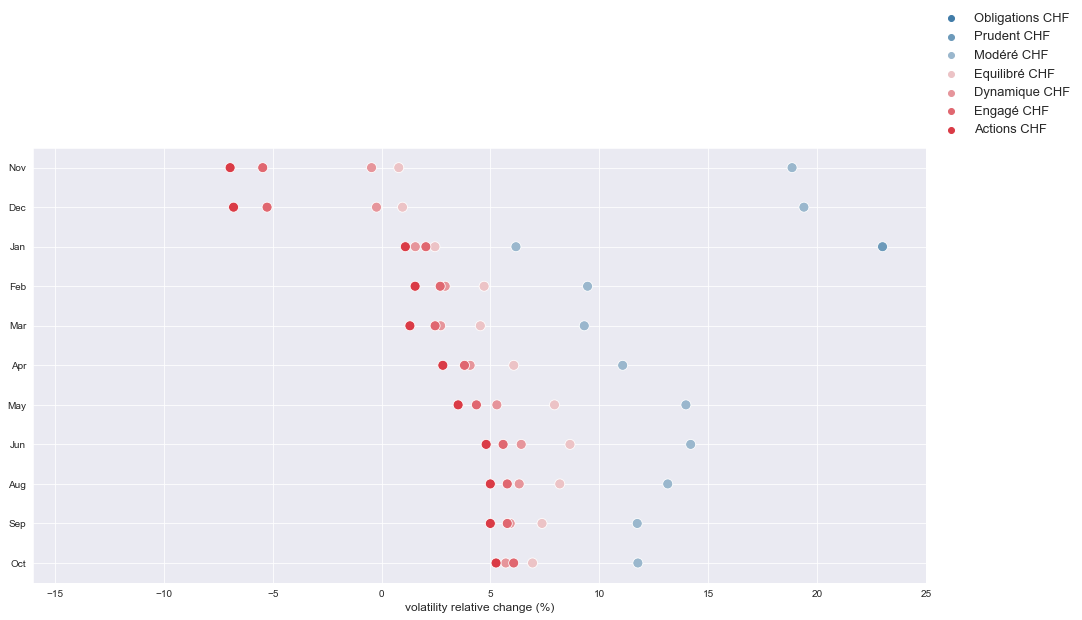

In [35]:
# display(df_vol_strats_diff.round(2).dropna())

data = df_vol_strats_pct.reset_index().melt(id_vars='date', var_name='strategie', value_name='volatility' )
data.date = data.date.dt.strftime('%b')

fig = plt.figure(figsize=(16,8))
pal = sns.diverging_palette(240, 10, n=len(df_vol_strats_diff.columns) + 2)
del pal[3:5]

ax = sns.scatterplot(data=data, x='volatility', y='date', hue='strategie', palette=pal, s=100, legend=True)

handles, labels = ax.get_legend_handles_labels()
lgd = ax.legend(handles, labels, bbox_to_anchor=(1, 1), fontsize=13, frameon=False)

plt.ylabel(None)
plt.xlabel('volatility relative change (%)', fontsize=12)
#plt.title('Volatility absolute difference with SAA (Dec. 2020) at each rebalance date \n Comparison between strategies', fontweight='bold', fontsize=15)
plt.locator_params(axis='x', nbins=15)
plt.xlim(-16, 25)
ax.grid(b=True, which='major', color='white', linestyle='-')


plt.savefig('pp_output/analyse/volatility_rel_diff.png', bbox_inches='tight', dpi=300)

plt.show()